In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../spatial-clust-scripts-main/")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import sklearn.metrics

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define modularity score
import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [3]:
#### read in 4 cellsnap embeddings
snap_embed1 = np.load("../../data/saved_embedding/img_alpha0.6_dbGNN_0327.npy")
snap_embed2 = np.load("../../data/saved_embedding/img_alpha0.7_dbGNN_0327.npy")
snap_embed3 = np.load("../../data/saved_embedding/img_alpha0.8_dbGNN_0327.npy")
snap_embed4 = np.load("../../data/saved_embedding/img_alpha0.9_dbGNN_0327.npy")

print([snap_embed1.shape, snap_embed2.shape, snap_embed3.shape, snap_embed4.shape])

[(53500, 32), (53500, 32), (53500, 32), (53500, 32)]


In [4]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed1.shape[0], 10000, replace=False)
    
    snap_embed_sub1 = snap_embed1[indices]
    snap_embed_sub2 = snap_embed2[indices]
    snap_embed_sub3 = snap_embed3[indices]
    snap_embed_sub4 = snap_embed4[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    cond1_list = []
    cond2_list = []
    cond3_list = []
    cond4_list = []

    ## snap1
    snap_edges1 = graph.get_feature_edges(
        arr=snap_embed_sub1, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    
    ## snap2
    snap_edges2 = graph.get_feature_edges(
        arr=snap_embed_sub2, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    
    ## snap3
    snap_edges3 = graph.get_feature_edges(
        arr=snap_embed_sub3, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    
    ## snap4
    snap_edges4 = graph.get_feature_edges(
        arr=snap_embed_sub4, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    res_list = [round(x, 2) for x in np.arange (0.4, 2.6, 0.2)]
    for res in res_list:
        
        snap_ss1 = get_modularity(snap_embed_sub1.shape[0], snap_edges1, resolution = res)
        snap_ss2 = get_modularity(snap_embed_sub2.shape[0], snap_edges2, resolution = res)
        snap_ss3 = get_modularity(snap_embed_sub3.shape[0], snap_edges3, resolution = res)
        snap_ss4 = get_modularity(snap_embed_sub4.shape[0], snap_edges4, resolution = res)
        
        cond1_list.append(snap_ss1)
        cond2_list.append(snap_ss2)
        cond3_list.append(snap_ss3)
        cond4_list.append(snap_ss4)
        
    data = {'res':res_list, 'a0.6':cond1_list,
            'a0.7':cond2_list,'a0.8':cond3_list,
           'a0.9':cond4_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)

at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


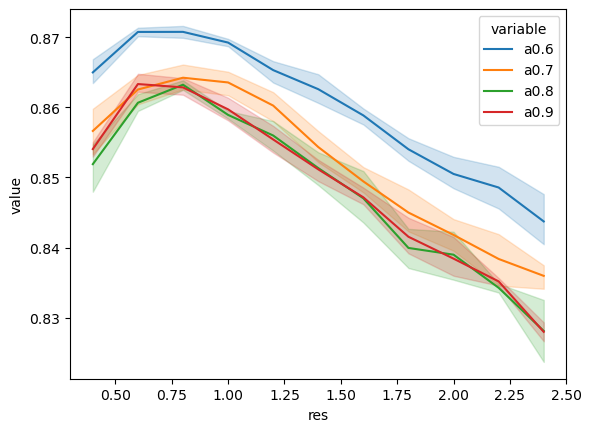

In [5]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['a0.6', 'a0.7', 'a0.8', 'a0.9'])
test2.to_csv('../../data/metrics/Mod_imgA_0327.csv')

plot = sns.lineplot(data=test2,x="res", y="value", hue="variable")
fig = plot.get_figure()
fig.savefig('../../plots/Mod_imgA_0327.svg', dpi = 300) 